# Access CRDB through REST interface

A [REST](https://en.wikipedia.org/wiki/Representational_state_transfer) interface is available at the following URL: http://lpsc.in2p3.fr/crdb/rest.php to query the database.

Click on the tab "REST interface" to see the list of parameters. Minimal required are the parameters `num` and `energy_type`. There are several optional parameters, see the website for details.

A REST query to the database is asking for data. The parameters specify what data to pull and in which format. The query URL has this format:

`url?par1=value1&par2=value2&...&parN=valueN`

where `url` is `http://lpsc.in2p3.fr/crdb/rest.php`, `par1` to `parN` are parameter names and `value1` to `valueN` are parameter values. Name and value pairs are connected by `=`, and individual pairs are linked by `&`.

The `num` parameter is the element, isotope, or particle, whose flux is requested. Valid values are `H`, `He`, `e+` written as `e%2B`, `3H`, etc. A flux ratio can be requested by also providing the optional `den` parameter, then `num` stands for numerator and `den` for denominator. The other parameter `energy_type`. It is used to request the energy unit. Valid values are `EKN`, `EK`, `R`, `ETOT`. See the website for details.

## Using wget

To start queries from a terminal we recommend the program `wget`, which is available for Linux and MacOSX (via homebrew).

The following command downloads all available boron-to-carbon flux ratios as a function of kinetic energy per nucleon, and save the output in a file called `db.txt`.

In [1]:
!wget 'http://lpsc.in2p3.fr/crdb/rest.php?num=B&den=C&energy_type=EKN' --output-document=db.txt

--2020-04-16 20:19:41--  http://lpsc.in2p3.fr/crdb/rest.php?num=B&den=C&energy_type=EKN
Resolving lpsc.in2p3.fr (lpsc.in2p3.fr)... 134.158.40.162
Connecting to lpsc.in2p3.fr (lpsc.in2p3.fr)|134.158.40.162|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://lpsc.in2p3.fr/crdb/_dialog_result.php?num=B&den=C&energy_type=EKN [following]
--2020-04-16 20:19:41--  http://lpsc.in2p3.fr/crdb/_dialog_result.php?num=B&den=C&energy_type=EKN
Reusing existing connection to lpsc.in2p3.fr:80.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘db.txt’

db.txt                  [ <=>                ]  68.59K   364KB/s    in 0.2s    

2020-04-16 20:19:42 (364 KB/s) - ‘db.txt’ saved [70240]



In [2]:
# first 25 lines of what we downloaded
!head -25 db.txt

# Data export from the Cosmic-Ray database (http://lpsc.in2p3.fr/crdb)
# Please cite Maurin, Melot, Taillet, A&A 569, A32 (2014) [arXiv:1302.5525]
# Date: 2020/04/16
# Format: USINE code
#   Col.1  -  QUANTITY NAME (case insensitive)
#   Col.2  -  SUB-EXP NAME (case insensitive, no space)
#   Col.3  -  EAXIS TYPE: EKN, EK, R, or ETOT
#   Col.4  -  <E>: mean value bin [GeV/n, GeV, GV, or GeV]
#   Col.5  -  EBIN_LOW
#   Col.6  -  EBIN_HIGH
#   Col.7  -  QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio
#   Col.8  -  ERR_STAT-
#   Col.9  -  ERR_STAT+
#   Col.10 -  ERR_SYST-
#   Col.11 -  ERR_SYST+
#   Col.12 -  ADS URL FOR PAPER REF (no space)
#   Col.13 -  phi [MV]
#   Col.14 -  DISTANCE EXP IN SOLAR SYSTEM [AU]
#   Col.15 -  DATIMES: format = yyyy/mm/dd-hhmmss:yyyy/mm/dd-hhmmss;...
#   Col.16 -  IS UPPER LIMIT: format = 0 or 1
#
B/C                                  ACE-CRIS(1998/01-1999/01)                     EKN        7.745970e-2     7.500000e-2     8.000000e-2     2.40700

## Using Python

Using a Python script is convenient if the queried data is directly going to processed further, or if multiple queries are going to be made.

The following code is a complete solution to query the database and convert the output to a numpy record array. The code was tested on Python3.7, but should work with older versions or Python3.

In [3]:
import requests
import numpy as np

def crdb_query(num=None, energy_type="EK", **kwargs):
    """
    Queries the CRDB and returns the table as a numpy array.
    
    Parameters are passed as keywords directly to this function.
    
    Parameters
    ----------
    num: str
        Element, isotope, or particle.
    energy_type: str (default: EK)
        Energy unit for the requested quantity. Valid values: EKN, EK, R, ETOT.
        
    Returns
    -------
    numpy record array with the database content
    """
    if num is None:
        raise KeyError("setting parameter `num` is required")
    valid_energy_types = ("EKN", "EK", "R", "ETOT")
    if energy_type.upper() not in valid_energy_types:
        raise ValueError("energy_type must be one of " + ",".join(valid_energy_types))
    kwargs["num"] = num
    kwargs["energy_type"] = energy_type.upper()
    urlcmd = "http://lpsc.in2p3.fr/crdb/rest.php?" + "&".join(["{0}={1}".format(k, v) for (k, v) in kwargs.items()])
    data = requests.get(urlcmd).content.decode("utf-8").split("\n")
    if len(data) == 1:
        raise ValueError(data[0])
    fields = [
        ("quantity", "U10"),
        ("sub_exp", "U100"),
        ("e_axis", "U4"),
        ("e_mean", "f8"),
        ("e_low", "f8"),
        ("e_high", "f8"),
        ("value", "f8"),
        ("err_stat_minus", "f8"),
        ("err_stat_plus", "f8"),
        ("err_sys_minus", "f8"),
        ("err_sys_plus", "f8"),
        ("ads_url", "U32"),
        ("phi_in_mv", "f8"),
        ("distance_in_au", "f8"),
        ("datetime", "U100"),
        ("is_upper_limit", "?")
    ]
    return np.genfromtxt(data, fields)

In [9]:
# get boron-to-carbon flux ratios measured in kinetic energy per nucleon as a numpy record array
tab = crdb_query(num="B", den="C", energy_type="EKN")

In [5]:
# print column names
for icol, col_name in enumerate(tab.dtype.fields):
    print("%2i" % icol, col_name)

 0 quantity
 1 sub_exp
 2 e_axis
 3 e_mean
 4 e_low
 5 e_high
 6 value
 7 err_stat_minus
 8 err_stat_plus
 9 err_sys_minus
10 err_sys_plus
11 ads_url
12 phi_in_mv
13 distance_in_au
14 datetime
15 is_upper_limit


In [6]:
# show mean energies, flux values, and which experiment collected the data of the first 20 entries
tab[["e_mean", "value", "sub_exp"]][:20]

array([( 0.0774597, 0.2407, 'ACE-CRIS(1998/01-1999/01)'),
       ( 0.09998  , 0.2473, 'ACE-CRIS(1998/01-1999/01)'),
       ( 0.117473 , 0.2489, 'ACE-CRIS(1998/01-1999/01)'),
       ( 0.134977 , 0.2571, 'ACE-CRIS(1998/01-1999/01)'),
       ( 0.150987 , 0.2555, 'ACE-CRIS(1998/01-1999/01)'),
       ( 0.162481 , 0.2654, 'ACE-CRIS(1998/01-1999/01)'),
       ( 0.45     , 0.323 , 'AMS01(1998/06)'),
       ( 0.73     , 0.334 , 'AMS01(1998/06)'),
       ( 1.18     , 0.339 , 'AMS01(1998/06)'),
       ( 1.92     , 0.302 , 'AMS01(1998/06)'),
       ( 3.11     , 0.265 , 'AMS01(1998/06)'),
       ( 5.06     , 0.234 , 'AMS01(1998/06)'),
       ( 8.22     , 0.199 , 'AMS01(1998/06)'),
       (13.36     , 0.175 , 'AMS01(1998/06)'),
       (21.72     , 0.141 , 'AMS01(1998/06)'),
       (35.3      , 0.126 , 'AMS01(1998/06)'),
       ( 0.446482 , 0.321 , 'AMS02(2011/05-2016/05)'),
       ( 0.537315 , 0.3251, 'AMS02(2011/05-2016/05)'),
       ( 0.639725 , 0.3214, 'AMS02(2011/05-2016/05)'),
       ( 0.755921

<IPython.core.display.Javascript object>


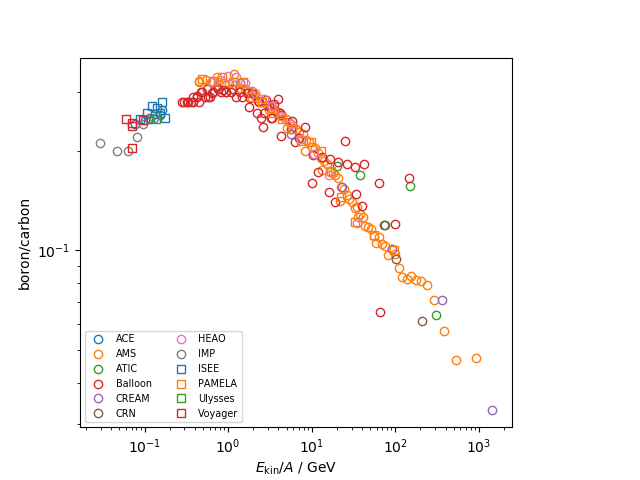

In [10]:
# let's plot the data
from matplotlib import pyplot as plt
import re
%matplotlib notebook

plt.figure()
plt.subplots_adjust(right=0.8)

# plot experiment with different color, show different versions with same color for simplicity
exps = {}
for x in tab["sub_exp"]:
    short = re.match("([A-Za-z]+)", x).group(1)
    y = exps.get(short, set())
    y.add(x)
    exps[short] = y

for i, (exp, sub_exps) in enumerate(exps.items()):
    mask = np.zeros(len(tab), dtype="?")
    for sub_exp in sub_exps:
        mask |= tab["sub_exp"] == sub_exp
    ncycle = 8
    plt.plot(tab["e_mean"][mask], tab["value"][mask],
             "osD"[i // ncycle], 
             color="None", markeredgecolor="C%i" % (i % ncycle),
             label=exp)

plt.legend(ncol=2, fontsize="x-small")
plt.xlabel("$E_\\mathrm{kin} / A$ / GeV")
plt.ylabel("boron/carbon")
plt.loglog();